In [ ]:
!pip install transformers
!pip install timm
!pip install datasets
!pip install evaluate

#역자 추가 코드
!pip install accelerate
!pip install torch
!pip install torchvision
!pip install scikit-learn
!pip install diffusers


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from timm import create_model
from transformers import default_data_collator
from datasets import load_dataset, DatasetDict, load_from_disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Kaggle API 설정

Step 1: Kaggle API 토큰 다운로드

Kaggle에 로그인합니다.
나의 로고(새)에서 Setting 페이지로 이동합니다.
API 섹션에서 Create New API Token 버튼을 클릭하여 kaggle.json 파일을 다운로드합니다.

Step 2: Colab에 Kaggle API 설정

kaggle.json 파일을 Colab에 업로드하고 API를 설정합니다.

In [ ]:
from google.colab import files

# kaggle.json 파일 업로드
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jasonyimlec","key":"c2341dec040995c5677d9492517a5dfa"}'}

In [ ]:
# Kaggle 디렉토리 생성 및 파일 이동
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Load the Dataset
1. There are three components of data:
  * Original Image: This image is in RGB format.
  * Label Image: This image is in grayscale format, with each pixel value ranging from 0 to 255. Most segmentation labeling tools categorize images into up to 256 categories. Each pixel value corresponds to a label category. We will provide more details on this when we review the data.
  * id2label: This is a mapping of IDs to label categories.
2. In our case the directory structure of dataset is like this: The images is jpg dataset with RGB format and labels is png dataset with png format
  

  ```
    -dataset
      |-train
        |-images
          |-1.jpg
          ...
        |-labels
          |-4.png
          ...
      |-test
        |-images
          |-1.jpg
          ...
        |-labels
          |-4.png
          ...
  ```
3. The following code loads the data and retrun as dataset class with following format:


    ```
    Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1708
    })
    ```
4. Each individual item of dataset looks like:


```
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x485>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x485>}
```











```
    '''
    def load_images_and_labels(image_directory, label_directory):
      image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".jpg")])
      label_files = sorted([f for f in os.listdir(label_directory) if f.endswith(".png")])

      data = []

      for image_file in image_files:
          file_name, _ = os.path.splitext(image_file)
          label_file = f"{file_name}.png"

          if label_file in label_files:
              with Image.open(os.path.join(image_directory, image_file)) as im:
                  img = im.copy()

              with Image.open(os.path.join(label_directory, label_file)) as im:
                  lbl = im.convert("L").copy()

              data.append({"pixel_values": img, "label": lbl})

      return data
      '''```



In [ ]:
# 런타임 3분~4분 소요
# Kaggle 데이터셋 다운로드
### 역자 주: 데이터셋은 https://www.kaggle.com/datasets/ggrill/foodseg103에서 다운로드 받습니다.
!kaggle datasets download -d ggrill/foodseg103

# 압축 해제 (이 코드 실행 전에 나의 구글 드라이브에 미리 foodseg103 폴더를 생성해 두어야 합니다.)
!unzip foodseg103.zip -d /content/drive/MyDrive/Book6/Ch8/


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007105.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007106.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007107.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007108.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007109.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007110.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007111.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007112.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007113.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch8/FoodSeg103/Images/img_dir/test/00007114.jpg  
  inflating: /content/drive/MyDrive/Book6/Ch

In [ ]:
import os
from PIL import Image
from datasets import Dataset
from concurrent.futures import ThreadPoolExecutor


def process_image(image_file, image_directory, label_directory):
    file_name, _ = os.path.splitext(image_file)
    label_file = f"{file_name}.png"

    with Image.open(os.path.join(image_directory, image_file)) as im:
        img = im.copy()

    with Image.open(os.path.join(label_directory, label_file)) as im:
        lbl = im.convert("L").copy()

    return {"pixel_values": img, "label": lbl}


def load_images_and_labels(image_directory, label_directory):
    image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".jpg")])
    label_files = sorted([f for f in os.listdir(label_directory) if f.endswith(".png")])

    data = []

    with ThreadPoolExecutor() as executor:
        results = executor.map(process_image, image_files, [image_directory]*len(image_files), [label_directory]*len(image_files))
        for result in results:
            data.append(result)

    return data


def create_image_segmentation_dataset(image_directory, label_directory):
      data = load_images_and_labels(image_directory, label_directory)
      dataset = Dataset.from_dict({"pixel_values": [item["pixel_values"] for item in data], "label": [item["label"] for item in data]})

      return dataset


In [ ]:
### 원래 데이터셋 FoodSeg103을 사용하면 코랩 램 제한으로 실행이 중간에 중단됩니다.
### 때문에 이미지 수를 각기 100개로 줄인 FoodSeq103_short를 책의 코드집에서 제공하고 있습니다.
### 이를 여러분의 구글 드라이브의 아래 디렉토리에 업로드하고 나서 아래 코드를 실행합니다.

# 학습 데이터셋 이미지 경로
image_directory = "/content/drive/MyDrive/Book6/Ch8/FoodSeg103_short/Images/img_dir/train"

# 학습 데이터셋 레이블 경로
label_directory = "/content/drive/MyDrive/Book6/Ch8/FoodSeg103_short/Images/ann_dir/train"

# Google Drive에 저장할 경로
output_path = "/content/drive/MyDrive/Book6/Ch8/train_dataset.hf"

# 데이터셋 생성 함수 호출
# create_image_segmentation_dataset 함수는 바로 위 코드 블록 참조
train_dataset = create_image_segmentation_dataset(image_directory,
                                                  label_directory)

# Hugging Face Dataset을 Google Drive에 저장
train_dataset.save_to_disk(output_path)
print(f"Dataset saved to {output_path}")

Saving the dataset (0/1 shards):   0%|          | 0/99 [00:00<?, ? examples/s]

Dataset saved to /content/drive/MyDrive/Book6/Ch8/train_dataset.hf


In [ ]:
train_dataset=load_from_disk("/content/drive/MyDrive/Book6/Ch8/train_dataset.hf")
train_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 99
})

## Let's review the data if it is in the correct format

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 99
})

# Let's create train and test split

In [ ]:
# 원서 코드는 바로 아래 숫자값이 0.98이나 이미지 수가 줄어 0.7로 수정
train_test_split_ratio = 0.7
train_size = int(train_test_split_ratio * len(train_dataset))
test_size = len(train_dataset) - train_size
split_ds = train_dataset.train_test_split(train_size=train_size, test_size=test_size, seed=42)
final_ds = DatasetDict({"train": split_ds["train"], "test": split_ds["test"]})
train_ds=split_ds["train"]
test_ds=split_ds["test"]


# Let's create dictionary that maps between the category ID and Category Name

In [ ]:
### 역자 추가 코드
base_dir = "/content/drive/MyDrive/Book6/Ch8/FoodSeg103_short/"

In [ ]:
id2label = {}

with open(base_dir+"category_id.txt", "r") as file:
    for line in file:
        id_, label = line.strip().split("\t")
        id2label[int(id_)] = label
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [ ]:
print(id2label)
print(label2id)

{0: 'background', 1: 'candy', 2: 'egg tart', 3: 'french fries', 4: 'chocolate', 5: 'biscuit', 6: 'popcorn', 7: 'pudding', 8: 'ice cream', 9: 'cheese butter', 10: 'cake', 11: 'wine', 12: 'milkshake', 13: 'coffee', 14: 'juice', 15: 'milk', 16: 'tea', 17: 'almond', 18: 'red beans', 19: 'cashew', 20: 'dried cranberries', 21: 'soy', 22: 'walnut', 23: 'peanut', 24: 'egg', 25: 'apple', 26: 'date', 27: 'apricot', 28: 'avocado', 29: 'banana', 30: 'strawberry', 31: 'cherry', 32: 'blueberry', 33: 'raspberry', 34: 'mango', 35: 'olives', 36: 'peach', 37: 'lemon', 38: 'pear', 39: 'fig', 40: 'pineapple', 41: 'grape', 42: 'kiwi', 43: 'melon', 44: 'orange', 45: 'watermelon', 46: 'steak', 47: 'pork', 48: 'chicken duck', 49: 'sausage', 50: 'fried meat', 51: 'lamb', 52: 'sauce', 53: 'crab', 54: 'fish', 55: 'shellfish', 56: 'shrimp', 57: 'soup', 58: 'bread', 59: 'corn', 60: 'hamburg', 61: 'pizza', 62: ' hanamaki baozi', 63: 'wonton dumplings', 64: 'pasta', 65: 'noodles', 66: 'rice', 67: 'pie', 68: 'tofu', 

# Plot the image and label

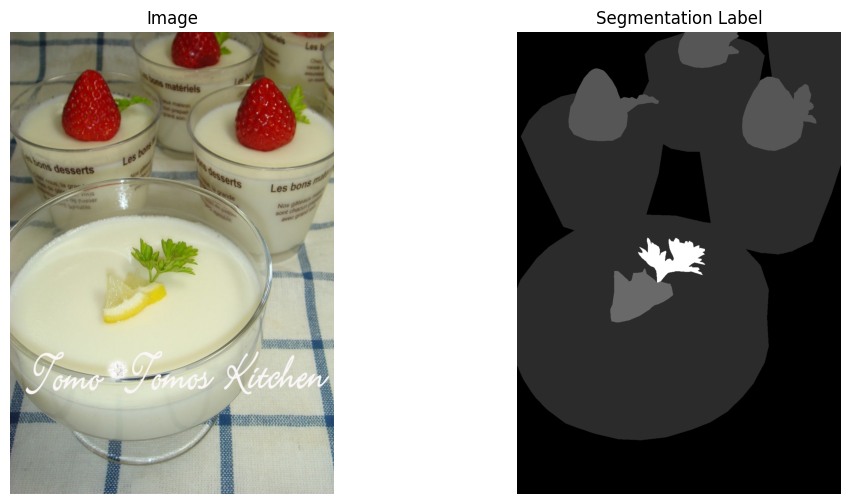

In [ ]:
import matplotlib.pyplot as plt

data=train_ds[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(data['pixel_values'])
ax1.set_title("Image")
ax1.axis("off")

ax2.imshow(data['label'], cmap="gray")
ax2.set_title("Segmentation Label")
ax2.axis("off")
# 이미지에서 유일한(Unique) 카테고리: [ 0 48 84 85 87]

plt.show()

### Unique pixel values on Label


In [ ]:
label=train_ds[0]['label']
import numpy as np
r_channel_array = np.array(label)

# Red 채널의 유일한(unique) 카테고리 IDs 탐색
unique_categories = np.unique(r_channel_array)

print("Unique categories in the image:", unique_categories)

Unique categories in the image: [ 0 15 30 37 89]


### Analysis:

### 역자 주: 데이터셋을 100여개의 적은 이미지만 사용하게 수정했기에 아래 해석과 다름
### 역자 주: 아래 해석은 원래 FoodSeq103 full 데이터셋을 사용했을 때의 결과를 해석한 결과임
1. The unique pixel values on our above label image are: [ 0, 10, 52]
2. From id2Labels dictionary: {0: 'background', 10: 'cake', 52: 'sauce'}
3. If we recall our earlier statement "Each pixel value corresponds to a label category". This seems to be correct.


# Transformation
1. jitter: The ColorJitter class applies random adjustments to an image's color properties
2. feature_extractor[SegformerFeatureExtractor]: Pre-process the image and segmentation map
  * it is the class to process the image and label for the Segformer model
  * it resizes the image
  * convert image into tensor
  * normalize the image
  * one-hot encode the label

In [ ]:
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, Compose
from transformers import SegformerFeatureExtractor
from torchvision.transforms import ColorJitter


feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
# 모델 선언

In [ ]:
from transformers import SegformerForSemanticSegmentation

model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# let's Create the training arguments

In [ ]:
from transformers import TrainingArguments

epochs = 10
lr = 3e-5
batch_size = 4

training_args = TrainingArguments(
    '/content/drive/MyDrive/Book6/Ch8/run',  # 출력 디렉토리 변경
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=10000,
    eval_steps=1000,
    logging_steps=500,
    eval_accumulation_steps=10,
    load_best_model_at_end=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Let's create function to calculate the evaluation metrics. This is what we are doing.
We are using IOU


```
IoU = (Intersection of predicted mask and ground truth mask) / (Union of predicted mask and ground truth mask)
```
* IOU equal to 1 signifies the predicted mask and the ground truth mask are identical,
* IOU equal to where 0 indicates no overlap between the predicted mask and the ground truth mask,

1. The input to the calculate_segmentation_metrics function is a tuple containing the predicted logits and the ground truth labels.
2. As the predicted logits may have a lower spatial resolution than the ground truth labels, we need to resize the logits to match the size of the ground truth. We use bilinear interpolation for resizing the logits.
3. we take the argmax operation along the channel dimension to obtain the predicted labels.
4. After converting the predicted labels to a NumPy array, we compute the mean IoU metric using the iou_metric._compute() function. This function compares the predicted labels to the ground truth labels and calculates the IoU for each class.
5. The iou_metric._compute() function returns a dictionary containing the overall mean IoU, per-category accuracy, and per-category IoU.

In [ ]:
import evaluate
import torch
from torch import nn

iou_metric = evaluate.load("mean_iou")

def calculate_segmentation_metrics(prediction_ground_truth):
    with torch.no_grad():
        logits, ground_truth = prediction_ground_truth
        logits_as_tensor = torch.from_numpy(logits)

        # segmentation 모델 학습 시, output(logits)이 ground_truth 레이블에 비교해서
        # 낮은 해상도(spatial resolution)을 갖게 됨
        # 때문에 logits를 조정(resize)해서 ground_truth 레이블 사이즈와 매칭시킴

        resized_logits = nn.functional.interpolate(
            logits_as_tensor,
            size=ground_truth.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        # 넘파이로 변환 전에 cpu로 전송
        predicted_labels = resized_logits.detach().cpu().numpy()

        # 평균 IoU(mean IoU) 메트릭(metric) 계산
        segmentation_metrics = iou_metric._compute(
            predictions=predicted_labels,
            references=ground_truth,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

        # 개별적인 키-값(key-value) 쌍으로서 카테고리당(per-category) 메트릭(metrics) 추출
        category_accuracy = segmentation_metrics.pop("per_category_accuracy").tolist()
        category_iou = segmentation_metrics.pop("per_category_iou").tolist()

        # 카테고리당(per-category) 정확도와 IoU로 메트릭 딕셔너리 업데이트
        segmentation_metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(category_accuracy)})
        segmentation_metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(category_iou)})

    return segmentation_metrics


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=calculate_segmentation_metrics,
)

In [ ]:
### 역자 추가 코드:
!pip install wandb

In [ ]:
### 역자 추가 코드
# WandB 초기화
import wandb
wandb.init(project="segmentation_project", name="run_name")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=180, training_loss=3.220948961046007, metrics={'train_runtime': 144.2933, 'train_samples_per_second': 4.782, 'train_steps_per_second': 1.247, 'total_flos': 1.217963759763456e+16, 'train_loss': 3.220948961046007, 'epoch': 10.0})

In [ ]:
save_directory = '/content/drive/MyDrive/Book6/Ch8/model/'
model.save_pretrained(save_directory)

In [ ]:
load_directory = save_directory

loaded_model = SegformerForSemanticSegmentation.from_pretrained(
    load_directory,
    id2label=id2label,
    label2id=label2id
)

# Let's Use the Model for Inference.

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


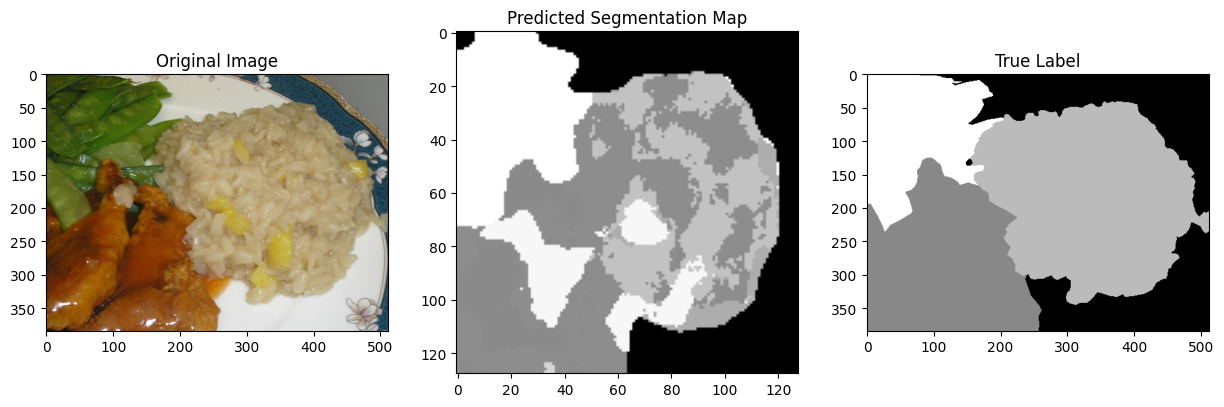

In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from transformers import SegformerFeatureExtractor
from matplotlib import pyplot as plt

# 피처 추출기 불러오기
feature_extractor = SegformerFeatureExtractor()

# 입력 이미지 불러오기(아래 경로는 여러분 구글 드라이브의 알맞은 경로로 변경)
image = Image.open('/content/drive/MyDrive/Book6/Ch8/FoodSeg103_short/Images/img_dir/train/00000000.jpg').convert("RGB")

# 입력 이미지 전처리
inputs = feature_extractor(images=[image], return_tensors="pt")

# 세그먼테이션(segmentation) 예측 계산
with torch.no_grad():
    outputs = loaded_model(**inputs)
    predictions = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

# id2label 매핑을 사용한 예측된 segmentation 맵에서 흑백(회색조) 컬러 맵 생성
grayscale_map = np.zeros((predictions.shape[0], predictions.shape[1]), dtype=np.uint8)
for label_id in id2label.keys():
    grayscale_map[predictions == label_id] = label_id

# 흑백(회색조) 맵에서 PIL 이미지로 변환
segmentation_image = Image.fromarray(grayscale_map, mode='L')

# true 레이블 이미지 불러오기
true_label_path = '/content/drive/MyDrive/Book6/Ch8/FoodSeg103_short/Images/ann_dir/train/00000000.png'
true_label = Image.open(true_label_path).convert("L")

# 원래 이미지, 예측된 세그멘테이션 맵 및 true 레이블 디스플레이
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image)
ax1.set_title("Original Image")
ax2.imshow(segmentation_image, cmap='gray')
ax2.set_title("Predicted Segmentation Map")
ax3.imshow(true_label, cmap='gray')
ax3.set_title("True Label")
plt.show()


# Let's Upload the model to the HuggingFace

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
loaded_model.push_to_hub("segformer-b0-finetuned-food")

pytorch_model.bin:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/prem-timsina/segformer-b0-finetuned-food/commit/3acb8201c4ca5632a5c77b51895c9f045c217c52', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='3acb8201c4ca5632a5c77b51895c9f045c217c52', pr_url=None, pr_revision=None, pr_num=None)